# Chest X-Ray Images (Pneumonia)
**Authors:** Carlos McCrum, Jared Mitchell, Andrew Bernklau
***

## Overview

We've been tasked to build a model to classify images that consist of x-rays of infected and healthy lungs at our local hospital. The data contains thousands of images Mendeley Data. We start buy preprocessing the images and splitting into training and test sets. Next we build different models to see what perfoms best, including Logistic Regression, Random Forest and Neural Networks. Convolutional neural networks perfomed best and had the best accuracy. So our recommendations would include convolutional neural networks for classification as they perfomed the best. 
***

## Business Problem

The goal of our project is to build a image classification model that can correctly identify between x-rays of infected and healthy lungs. It's important that our model has high accuracy. With a low accuracy our model would misdiagnose too much or fail to diagnose someone who has pneumonia. Classifying images requires a lot of images for more accurate modeling and we are limited in the number of images we have at our disposal. We chose this route to see if modeling could help classify whether a person does or does not have a the Pneumonia to help radiology technicians at our local hospital.  

***

## Data Understanding

Our data comes from Mendeley Data, it contains a few thousand images Chest X-Ray described and analyzed in "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning". The images are split into a training set and a testing set of independent patients. Images are labeled as (disease)-(randomized patient ID)-(image number by this patient). We are going to be classifying whether the images fall into the two classes either "NORMAL" or "PNEUMONIA"". We start buy preprocessing the data, then spliting it into training and validation sets then build a few different models to see what model perfoms best. 

***

In [1]:
# Import packages
from sklearn.linear_model import LogisticRegression
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os 
import cv2
from random import shuffle 
from tqdm import tqdm 
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
from keras.layers import Dense, BatchNormalization
from keras.models import Sequential
from keras.losses import MeanSquaredError
from scipy import ndimage
import tensorflow_probability as tfp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

## Data Preparation

We preprocessed the data in two ways. One for our logistic and random forest models spliting our data the standard way, and the other we preprocessed our images into tensors for our neural network modeling. We did it this way to have our images properly set for our models for the best performance. There were very few images that would not load and were discarded, there were no other null values in our data. 

***

### Preprocessing for Logitstic and Random Forest

Set path for our images.

In [2]:
train_path = 'data/chest_xray/train/'
test_path = 'data/chest_xray/test/'
val_path = 'data/chest_xray/val'

In [3]:
# get all the data in the directory chest_xray/test (624 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_path,
        batch_size = 624) 

# get all the data in the directory split/validation (16 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_path,
        batch_size = 16)

# get all the data in the directory split/train (5216 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255, shear_range = 0.2, zoom_range = 0.2).flow_from_directory(
        train_path,
        batch_size=5217)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5218 images belonging to 2 classes.


- Create datasets and reshape for our models to interpret. 

In [4]:
# create the data sets
val_images, val_labels = tqdm(next(val_generator))
test_images, test_labels = tqdm(next(test_generator))
train_images, train_labels = tqdm(next(train_generator))

100%|██████████| 2/2 [00:00<00:00, 9653.17it/s]


- Data Augmentation

In [5]:
dataAug = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 45,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


dataAug.fit(train_images)

In [6]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5217, 196608)
(624, 196608)
(16, 196608)


In [7]:
train_y = np.reshape(train_labels[:,0], (5217,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

Pneumonia    0.742764
Normal       0.257236
dtype: float64


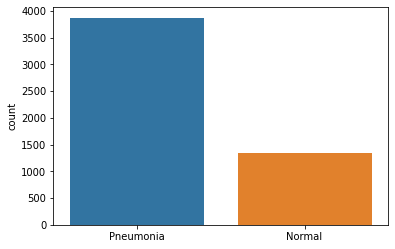

In [8]:
mask = []
for i in train_labels:
    if(i[1] == 1):
        mask.append("Pneumonia")
    else:
        mask.append("Normal")
sns.countplot(mask)
print(pd.DataFrame(mask).value_counts(normalize=True));

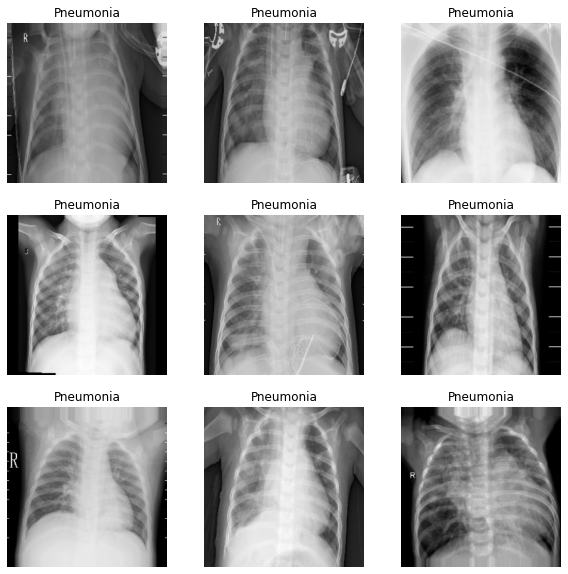

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(array_to_img(train_images[i]))
    if train_y[i] == 0:
        plt.title("Pneumonia")
    else :
        plt.title("Normal")
    plt.axis("off")

### Preprocessing for Neural Networks

- Creating a tensorflow dataset for our model to interpret.

In [10]:
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5218 files belonging to 2 classes.
Using 4175 files for training.
Found 624 files belonging to 2 classes.
Using 124 files for validation.


See the shape of our data.

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


See the classes to confirm our two classes 'Normal' and 'Pneumonia'

In [12]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [13]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

Preview our data.

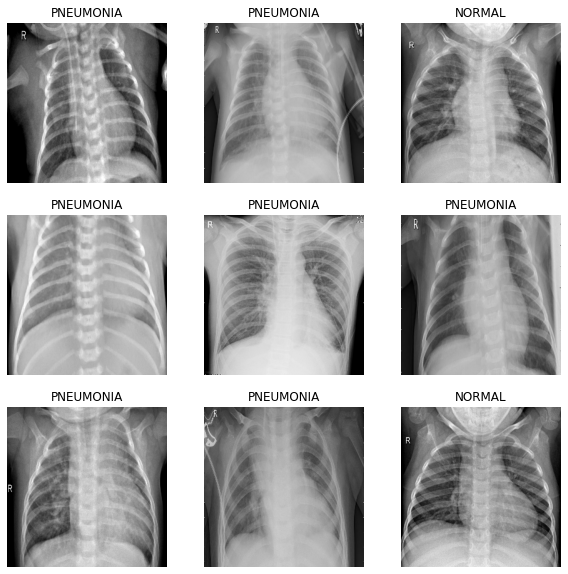

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

##### Data Augmentation

## Data Modeling
We start off with a simple logistical regression model to see how it performs, we next move on to random forest modeling to see if we can get a better accuracy score and we do, last we try convolutional neural networks to see how accurate we can make it so we don't have any false positives or false negatives. These are all models that work for classification, lets see how they perform. 

Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

Start by running a logistical regression model as our baseline. 

In [15]:
log = LogisticRegression(penalty='l2')
log.fit(train_img, train_y)
print(f'Test Score: {log.score(test_img, test_y)}')

Test Score: 0.8189102564102564


Very good start, now we move on to our random forest to see if we can improve these results. 

In [16]:
RFmodel = RandomForestClassifier(criterion= 'entropy', max_depth= 15, min_samples_split= 5, 
                               n_estimators= 700, random_state=777,max_features='log2')
RFmodel.fit(train_img, train_y)
print(cross_val_score(RFmodel, test_img, test_y, cv=5))
print(RFmodel.score(test_img, test_y))

[0.904      0.88       0.904      0.904      0.90322581]
0.842948717948718


Add a tuner to help our models.
>From tensorflow, "Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache. Dataset.prefetch overlaps data preprocessing and model execution while training."

In [36]:
np.random.seed(123)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(.005))),
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

history = model.fit(train_images,
                    train_y,
                    steps_per_epoch=20,
                    epochs=20,
                    batch_size=16,
                    validation_data=(val_images, val_y))



print(f"Training Score: {model.evaluate(train_images, train_y)}")
print(f"Test Score: {model.evaluate(test_images, test_y)}")


Epoch 1/20
20/20 [==============================] - 9s 389ms/step - loss: 1.1397 - acc: 0.6687 - val_loss: 1.0962 - val_acc: 0.5000
Epoch 2/20
20/20 [==============================] - 7s 366ms/step - loss: 0.9246 - acc: 0.7375 - val_loss: 1.1112 - val_acc: 0.5000
Epoch 3/20
20/20 [==============================] - 8s 377ms/step - loss: 0.8980 - acc: 0.7406 - val_loss: 1.1099 - val_acc: 0.5000
Epoch 4/20
20/20 [==============================] - 7s 368ms/step - loss: 0.8639 - acc: 0.7594 - val_loss: 1.1875 - val_acc: 0.5000
Epoch 5/20
20/20 [==============================] - 8s 386ms/step - loss: 0.8659 - acc: 0.7406 - val_loss: 0.9743 - val_acc: 0.5000
Epoch 6/20
20/20 [==============================] - 8s 374ms/step - loss: 0.8601 - acc: 0.7375 - val_loss: 1.1057 - val_acc: 0.5000
Epoch 7/20
20/20 [==============================] - 8s 386ms/step - loss: 0.8177 - acc: 0.7437 - val_loss: 1.1643 - val_acc: 0.5000
Epoch 8/20
20/20 [==============================] - 8s 391ms/step - loss: 0.

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255), 
  tf.keras.layers.Conv2D(32 , (3,3), activation = 'relu', kernel_regularizer=regularizers.l1_l2(.005)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(64 , (3,3) , activation = 'relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])



history2 = model.fit(train_ds,
                    epochs=3,
                    steps_per_epoch=20,
                    batch_size=32,
                    validation_data=(test_ds))

print(f"Training Score: {model.evaluate(train_ds)}")
print(f"Test Score: {model.evaluate(test_ds)}")



Epoch 1/3
20/20 [==============================] - 61s 3s/step - loss: 2.9758 - accuracy: 0.7750 - val_loss: 13.2927 - val_accuracy: 0.3548
Epoch 2/3
20/20 [==============================] - 57s 3s/step - loss: 0.5698 - accuracy: 0.9422 - val_loss: 5.6323 - val_accuracy: 0.5161
Epoch 3/3
131/131 [==============================] - 105s 803ms/step - loss: 12.5031 - accuracy: 0.7344
Training Score: [12.503118515014648, 0.7343712449073792]
4/4 [==============================] - 3s 863ms/step - loss: 17.9720 - accuracy: 0.6452
Test Score: [17.97195053100586, 0.6451612710952759]


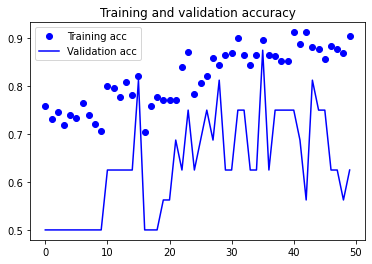

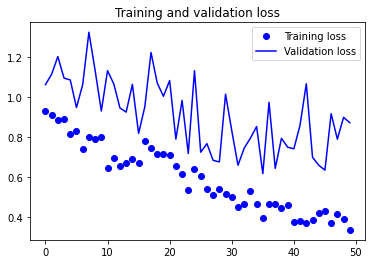

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Evaluation
Our best model came out to 84% accuracy score. 

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***